In [1]:
import pandas as pd
import numpy as np
import os

os.listdir('./')

['.ipynb_checkpoints',
 '300전사들.pptx',
 'Cluster0_modeling.ipynb',
 'Cluster1_modeling.ipynb',
 'cluster_df.csv',
 'Cluster_modeling_sohyun.ipynb',
 'final_modeling1.ipynb',
 'final_modeling2.ipynb',
 'test.csv',
 'train.csv']

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
cluster_df = pd.read_csv('./cluster_df.csv')
train['train'] = 1
test['train'] = 0

df = pd.concat([train, test])
df = pd.merge(df, cluster_df, how = 'left')
df.shape

(1489618, 44)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["days"] = lb_make.fit_transform(df["days"])
df["direction"] = lb_make.fit_transform(df["direction"])
df["road_type"] = lb_make.fit_transform(df["road_type"])
df["urban_suburb"] = lb_make.fit_transform(df["urban_suburb"])
df["district"] = lb_make.fit_transform(df["district"])
df["time"] = lb_make.fit_transform(df["time"])

In [5]:
def rain_level(rain) :
    if rain >= 30 :
        return 3
    else :
        if rain >=15 :
            return 2
        else :
            if rain >=3 :
                return 1
            else : return 0

def dust_PM2_level(dust) :
    if dust >= 76 :
        return 3
    else :
        if dust >=36 :
            return 2
        else :
            if dust >=16 :
                return 1
            else : return 0      

def dust_PM10_level(dust) :
    if dust >= 151 :
        return 3
    else :
        if dust >=81 :
            return 2
        else :
            if dust >=31 :
                return 1
            else : return 0

def wind_level(wind) :
    if wind >= 14 :
        return 3
    else :
        if wind >=9 :
            return 2
        else :
            if wind >=4 :
                return 1
            else : return 0

def O3_level(O3) :
    if O3 >= 0.151 :
        return 3
    else :
        if O3 >=0.091 :
            return 2
        else :
            if O3 >=0.031 :
                return 1
            else : return 0
            
df['dust_PM10_level'] = df['PM10'].apply(lambda x : dust_PM10_level(x))
df['dust_PM2_level'] = df['PM2.5'].apply(lambda x : dust_PM2_level(x))
df['rain_level'] = df['rain'].apply(lambda x : rain_level(x))       
df['wind_level'] = df['wind'].apply(lambda x : wind_level(x))            
df['O3_level'] = df['O3'].apply(lambda x : O3_level(x))

df['hsv'] = df['holiday'] + df['special'] + df['vacation']
df['cctv_kids'] = df['cctv'] + df['kids']

df['cctv_length'] = df['cctv'] / df['road_length']
df['kids_length'] = df['kids'] / df['road_length']
df['entrance_length'] = df['entrance'] / df['road_length']
df['signal_length'] = df['signal'] / df['road_length']

df['cctv_num'] = df['cctv'] / df['inter_num']
df['kids_num'] = df['kids'] / df['inter_num']
df['entrance_num'] = df['entrance'] / df['inter_num']
df['signal_num'] = df['signal'] / df['inter_num']

bins = [0,500,1000,1500,2000,4000]
bins_names = [0,1,2,3,4] # 구간별 이름
df['severity_level'] = pd.cut(df['severity'], bins, labels=bins_names)

bins = [-40,-10,10,20,30,50]
bins_names = [0,1,2,3,4] # 구간별 이름
df['temp_level'] = pd.cut(df['temperature'], bins, labels=bins_names)

In [6]:
cols = ['days','time','road_type','month','temp_level','rain_level','dust_PM10_level',
       'dust_PM2_level', 'rain_level', 'wind_level', 'O3_level','severity_level']

df_dummy = pd.get_dummies(df, columns=cols)
df_dummy.shape

(1489618, 116)

In [7]:
df = pd.concat([df_dummy, df[cols]], axis = 1)
df.shape

(1489618, 128)

In [8]:
cols = ['d1', 'd2', 'd3', 'd4','victims', 'severity', 'accident_count']

for col in cols :
    df[col + '_length'] = df[col] / df['road_length']
    df[col + '_num'] = df[col] / df['inter_num']

In [9]:
def seasonal(month) :
    if (month <= 5) & (month >= 3):
        return 0
    elif (month >= 6) & (month >= 8):
        return 1
    elif (month >= 9) & (month >= 11):
        return 2
    else :
        return 3
df['season'] = df['month'].apply(lambda x : seasonal(x))

# Cluster 0

In [10]:
c0 = df[df.cluster == 0]
c0.shape

c0 = c0.drop(['date','road_name','link_id','start_point','end_point'],axis = 1)
c0.drop(c0.var().index[c0.var() == 0],axis = 1, inplace = True)
c0 = c0.reset_index(drop = True)

train = c0[c0.train == 1]
test = c0[c0.train == 0]

print('train shape : ', train.shape)
print('test shape : ', test.shape)

train shape :  (461717, 135)
test shape :  (197809, 135)


In [11]:
X_train = train.drop(['y', 'train'], axis = 1)
y_train = train.y

X_test = test.drop(['y','train'], axis = 1)
y_test = test.y

print((X_train.shape, X_test.shape), (y_train.shape, y_test.shape))

((461717, 133), (197809, 133)) ((461717,), (197809,))


In [12]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred) : 
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [13]:
def rmse_print(model) :
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('{0} test rmse : {1:.3f}'.format(model.__class__.__name__, rmse(y_test, y_pred)))

In [ ]:
def model_cv_test(model, train_X, train_y, test_X, test_y, is_log) :

    train_rmse = []
    valid_rmse = []
    
    print('##### {} #####'.format(model.__class__.__name__))
        
    for i, (train_idx, val_idx) in enumerate(kf.split(train_X)):
        X_train, X_val = train_X.iloc[train_idx, :], train_X.iloc[val_idx, :]
        y_train, y_val = train_y[train_idx], train_y[val_idx]

        model.fit(X_train, y_train)
        
        if is_log :
            y_train = np.expm1(y_train)
            y_val = np.expm1(y_val)
            pred_train = np.expm1(model.predict(X_train))
            pred_valid = np.expm1(model.predict(X_val))
        else :
            pred_train = model.predict(X_train)
            pred_valid = model.predict(X_val)

        print('{0} fold train rmse : {1:.3f} valid rmse : {2:.3f}'.format(i, rmse(y_train, pred_train), rmse(y_val, pred_valid)))
        
        train_rmse.append(rmse(y_train, pred_train))
        valid_rmse.append(rmse(y_val, pred_valid))

    print('\n')    
    print('mean train rmse : {0:.3f} mean valid rmse : {1:.3f}'.format(np.mean(train_rmse), np.mean(valid_rmse)))

    
    model.fit(train_X, train_y)
    
    if is_log :
        test_y = np.expm1(test_y)
        pred_test = np.expm1(model.predict(test_X))
    else :
        pred_test = model.predict(test_X)
    
    print('test rmse {0:.3f} '.format(rmse(test_y, pred_test)))

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 3, random_state = 333)

# OLS

In [26]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
lr = LinearRegression()

In [27]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc.fit(X_train)
X_train_sc = pd.DataFrame(sc.transform(X_train))
X_test_sc = pd.DataFrame(sc.transform(X_test))

In [29]:
model_cv_test(lr, X_train, y_train, X_test, y_test, False)

##### LinearRegression #####
0 fold train rmse : 7.997 valid rmse : 8.023
1 fold train rmse : 8.014 valid rmse : 7.989
2 fold train rmse : 8.003 valid rmse : 8.011


mean train rmse : 8.005 mean valid rmse : 8.008
test rmse 7.983 


# Ridge

In [30]:
ridge = Ridge()
model_cv_test(ridge, X_train_sc, y_train, X_test_sc, y_test, False)

##### Ridge #####
0 fold train rmse : 7.999 valid rmse : 8.024
1 fold train rmse : 8.016 valid rmse : 7.991
2 fold train rmse : 8.005 valid rmse : 8.012


mean train rmse : 8.007 mean valid rmse : 8.009
test rmse 7.984 


In [32]:
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits = 3, random_state = 333)
from bayes_opt import BayesianOptimization

In [33]:
def RidgeCV(alpha) :
    ridge = Ridge(alpha = alpha)
    rmse = np.sqrt(-cross_val_score(ridge, X_train,y_train, scoring = 'neg_mean_squared_error', cv = cv))
    return -rmse.mean()

In [34]:
pbounds = {'alpha' : (0,10)}

Ridge_Bo = BayesianOptimization(f = RidgeCV, pbounds = pbounds, verbose = 2, random_state = 1)
Ridge_Bo.maximize()

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -8.301    |  4.17     |
|  2        | -8.338    |  7.203    |
|  3        | -8.018    |  0.001144 |
|  4        | -8.277    |  3.023    |
|  5        | -8.216    |  1.468    |
|  6        | -8.357    |  10.0     |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.2841079607437454e-36
  ' condition number: {}'.format(rcond), RuntimeWarning)


|  7        | -1.206e+1 |  4.441e-1 |
|  8        | -8.301    |  4.17     |
|  9        | -8.277    |  3.023    |
|  10       | -8.277    |  3.023    |
|  11       | -8.216    |  1.468    |
|  12       | -8.277    |  3.023    |
|  13       | -8.357    |  10.0     |
|  14       | -8.338    |  7.203    |
|  15       | -8.338    |  7.203    |
|  16       | -8.216    |  1.468    |
|  17       | -8.216    |  1.468    |
|  18       | -8.216    |  1.468    |
|  19       | -8.357    |  10.0     |
|  20       | -8.216    |  1.468    |
|  21       | -8.216    |  1.468    |
|  22       | -8.018    |  0.001151 |
|  23       | -8.357    |  10.0     |
|  24       | -8.301    |  4.17     |
|  25       | -8.301    |  4.17     |
|  26       | -8.338    |  7.203    |
|  27       | -8.216    |  1.468    |
|  28       | -8.018    |  0.001144 |
|  29       | -8.357    |  10.0     |
|  30       | -8.357    |  10.0     |


In [35]:
ridge = Ridge(alpha=Ridge_Bo.max['params']['alpha'])
model_cv_test(ridge, X_train_sc, y_train, X_test_sc, y_test, False)

##### Ridge #####
0 fold train rmse : 7.997 valid rmse : 8.023
1 fold train rmse : 8.014 valid rmse : 7.989
2 fold train rmse : 8.003 valid rmse : 8.011


mean train rmse : 8.005 mean valid rmse : 8.008
test rmse 7.983 


In [36]:
ridge = Ridge(alpha=Ridge_Bo.max['params']['alpha'])
model_cv_test(ridge, X_train, y_train, X_test, y_test, False)

##### Ridge #####
0 fold train rmse : 8.007 valid rmse : 8.034
1 fold train rmse : 8.024 valid rmse : 7.999
2 fold train rmse : 8.014 valid rmse : 8.019


mean train rmse : 8.015 mean valid rmse : 8.018
test rmse 7.994 


# Lasso

In [37]:
lasso = Lasso()
model_cv_test(lasso, X_train_sc, y_train, X_test_sc, y_test, False)

##### Lasso #####
0 fold train rmse : 9.755 valid rmse : 9.796
1 fold train rmse : 9.776 valid rmse : 9.736
2 fold train rmse : 9.772 valid rmse : 9.771


mean train rmse : 9.768 mean valid rmse : 9.768
test rmse 9.754 


# RandomForest

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

In [42]:
model_cv_test(rf, X_train, y_train, X_test, y_test, False)

##### RandomForestRegressor #####
0 fold train rmse : 1.473 valid rmse : 3.461
1 fold train rmse : 1.474 valid rmse : 3.485
2 fold train rmse : 1.471 valid rmse : 3.477


mean train rmse : 1.473 mean valid rmse : 3.474
test rmse 3.287 


In [60]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

plt.figure(figsize = (5,5))
sns.regplot(y_test, rf_pred)
plt.show()

KeyboardInterrupt: 

# XGBoost

In [44]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_jobs = -1)

In [45]:
def model_cv_test2(model, train_X, train_y, test_X, test_y, is_log) :

    train_rmse = []
    valid_rmse = []
    
    print('##### {} #####'.format(model.__class__.__name__))
        
    for i, (train_idx, val_idx) in enumerate(kf.split(train_X)):
        X_train, X_val = train_X[train_idx, :], train_X[val_idx, :]
        y_train, y_val = train_y[train_idx], train_y[val_idx]

        model.fit(X_train, y_train)
        
        if is_log :
            y_train = np.expm1(y_train)
            y_val = np.expm1(y_val)
            pred_train = np.expm1(model.predict(X_train))
            pred_valid = np.expm1(model.predict(X_val))
        else :
            pred_train = model.predict(X_train)
            pred_valid = model.predict(X_val)

        print('{0} fold train rmse : {1:.3f} valid rmse : {2:.3f}'.format(i, rmse(y_train, pred_train), rmse(y_val, pred_valid)))
        
        train_rmse.append(rmse(y_train, pred_train))
        valid_rmse.append(rmse(y_val, pred_valid))

    print('\n')    
    print('mean train rmse : {0:.3f} mean valid rmse : {1:.3f}'.format(np.mean(train_rmse), np.mean(valid_rmse)))

    
    model.fit(train_X, train_y)
    
    if is_log :
        test_y = np.expm1(test_y)
        pred_test = np.expm1(model.predict(test_X))
    else :
        pred_test = model.predict(test_X)
    
    print('test rmse {0:.3f} '.format(rmse(test_y, pred_test)))

In [46]:
model_cv_test2(xgb, X_train.values, y_train, X_test.values, y_test, False)

##### XGBRegressor #####
[01:19:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0 fold train rmse : 5.659 valid rmse : 5.701
[01:19:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 fold train rmse : 5.661 valid rmse : 5.656
[01:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2 fold train rmse : 5.679 valid rmse : 5.663


mean train rmse : 5.666 mean valid rmse : 5.673
[01:21:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
test rmse 5.644 


# lightGBM

In [47]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_jobs = -1)

In [48]:
model_cv_test(lgb, X_train, y_train, X_test, y_test, False)

##### LGBMRegressor #####
0 fold train rmse : 4.172 valid rmse : 4.261
1 fold train rmse : 4.201 valid rmse : 4.222
2 fold train rmse : 4.207 valid rmse : 4.249


mean train rmse : 4.193 mean valid rmse : 4.244
test rmse 4.202 


In [49]:
def lgbCV(learning_rate, n_estimators, num_leaves, colsample_bytree, subsample, reg_alpha,reg_lambda) :
    lgb = LGBMRegressor(learning_rate = learning_rate, colsample_bytree = colsample_bytree,
                        n_estimators = int(n_estimators), num_leaves = int(num_leaves),
                        subsample = subsample, reg_alpha = reg_alpha,reg_lambda = reg_lambda)
    
    rmse = np.sqrt(-cross_val_score(lgb, X_train,y_train, scoring = 'neg_mean_squared_error', cv = cv))
    return -rmse.mean()

In [50]:
pbounds = {
    'learning_rate': (0.001,1),
    'n_estimators': (20,1000),
    'num_leaves': (4,20),
    'colsample_bytree' : (0.1,0.7),
    'subsample' : (0.1,0.8),
    'reg_alpha' : (1,1.8),
    'reg_lambda' : (1,1.5)
    }

lgb_Bo = BayesianOptimization(f = lgbCV, pbounds = pbounds, verbose = 2, random_state = 1)
lgb_Bo.maximize()

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -5.318    |  0.3502   |  0.7206   |  20.11    |  8.837    |  1.117    |  1.046    |  0.2304   |
|  2        | -3.765    |  0.3073   |  0.3974   |  548.0    |  10.71    |  1.548    |  1.102    |  0.7147   |
|  3        | -3.937    |  0.1164   |  0.6708   |  429.0    |  12.94    |  1.112    |  1.099    |  0.6605   |
|  4        | -3.442    |  0.681    |  0.3141   |  698.5    |  18.02    |  1.716    |  1.043    |  0.1273   |
|  5        | -4.395    |  0.2019   |  0.8783   |  116.4    |  10.74    |  1.766    |  1.267    |  0.5843   |
|  6        | -4.239    |  0.1      |  1.0      |  1e+03    |  4.0      |  1.0      |  1.5      |  0.8      |
|  7        | -10.65    |  0.1      |  0.001    |  827.0    |  4.0      |  1.0      |  1.5      |  0.8      |
|  8      

In [52]:
lgb_Bo.max

{'params': {'colsample_bytree': 0.68095694543163843,
  'learning_rate': 0.31411075398108362,
  'n_estimators': 698.47616335592784,
  'num_leaves': 18.022226436736613,
  'reg_alpha': 1.7156853308030779,
  'reg_lambda': 1.042522105684889,
  'subsample': 0.12733834826301765},
 'target': -3.4416905599925793}

In [53]:
lgb = LGBMRegressor(n_jobs = -1,colsample_bytree=lgb_Bo.max['params']['colsample_bytree'],
                    learning_rate=lgb_Bo.max['params']['learning_rate'],
                    n_estimators=698,
                    num_leaves=18,
                    reg_alpha=lgb_Bo.max['params']['reg_alpha'],
                    reg_lambda=lgb_Bo.max['params']['reg_lambda'],
                    subsample=lgb_Bo.max['params']['subsample'],
           )

model_cv_test(lgb, X_train, y_train, X_test, y_test, False)

##### LGBMRegressor #####
0 fold train rmse : 3.012 valid rmse : 3.468
1 fold train rmse : 3.017 valid rmse : 3.428
2 fold train rmse : 3.012 valid rmse : 3.430


mean train rmse : 3.014 mean valid rmse : 3.442
test rmse 3.348 


In [57]:
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

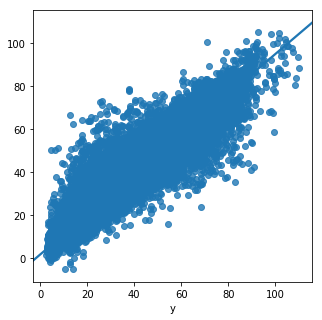

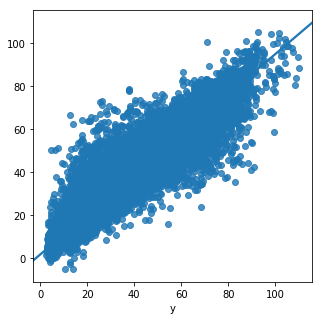

In [59]:
plt.figure(figsize = (5,5))
sns.regplot(y_test, lgb_pred)
plt.show()